In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
df = pd.read_csv(r'/content/drive/My Drive/DM/data/nlp-getting-started/train.csv')
test = pd.read_csv(r'/content/drive/My Drive/DM/data/nlp-getting-started/test.csv')

In [5]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


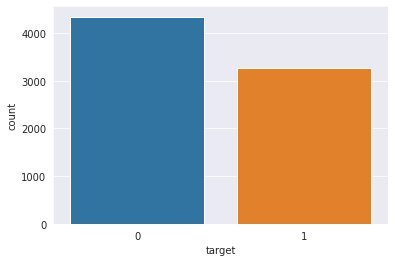

In [6]:
sns.countplot(df["target"]);

In [7]:
df["target"].value_counts(normalize = True) #normalized value counts

0    0.57034
1    0.42966
Name: target, dtype: float64

In [9]:
def len_plot(data, name):
  length = [len(sent.split()) for sent in data]
  plt.hist(length)
  plt.title(name)

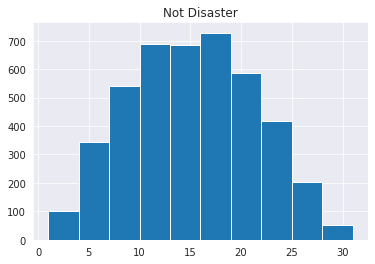

In [10]:
len_plot(df[df["target"]==0]["text"], "Not Disaster") #passing non disaster tweets

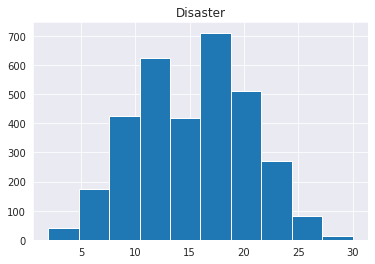

In [11]:
len_plot(df[df["target"]==1]["text"], "Disaster") #passing disaster tweets

In [12]:
X = df["text"] # indpendent
y = df["target"] # dependent
y = np.array(y) # converting into array

In [13]:
def unique_words(text):
  unique_words_list = []
  for sent in tqdm(text):
    for word in sent.split():
      if word.lower() not in unique_words_list:
        unique_words_list.append(word.lower())
      else:
        pass
  return unique_words_list
un_words = unique_words(X)

100%|██████████| 7613/7613 [00:11<00:00, 687.09it/s]


In [14]:
print("Total number of unique words :",len(un_words))

Total number of unique words : 27983


In [15]:
SYMBOL1 = "#"
words_sym1 = [word for word in un_words if word.startswith(SYMBOL1)]
len(words_sym1)

# words with starting letter "@"
SYMBOL2 = "@"
words_sym2 = [word for word in un_words if word.startswith(SYMBOL2)]
len(words_sym2)

2264

In [16]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [17]:
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()

In [27]:
def preprocessing(text):
  
  tweets = []
  for tweet in tqdm(text):
    tweet = tweet.lower() # converting to lower case
    tweet =  remove_urls(tweet) # url removing
    tweet = re.sub(r'@\w+',  '', tweet).strip() # removing the words start with "@"
    tweet = re.sub("[^a-zA-Z0-9 ']", "", tweet) # removing unwanted symbols
    tweet = tweet.split()
    tweet1 = [wl.lemmatize(word) for word in tweet if word not in set(stopwords.words("english"))] #lemmatization and stopwrds removal
    tweet1 = " ".join(tweet1)
    tweets.append(tweet1)
  return tweets

tweets = preprocessing(X)

100%|██████████| 7613/7613 [00:15<00:00, 476.55it/s]


In [28]:
# importing libraries
import tensorflow as tf
tf.__version__

from tensorflow.keras.layers import (Embedding,
                                     LSTM,
                                     Dense,
                                     Dropout,
                                     GlobalMaxPool1D,
                                     BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

In [42]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(tweets, test_size = 0.2, random_state = 42, stratify = y)
print(train)
print(val)
print(y)
VOC_SIZE = 30000
onehot_repr_train = [one_hot(words, VOC_SIZE) for words in train[0]]
onehot_repr_val = [one_hot(words, VOC_SIZE) for words in val]

SENT_LENGTH = 15
embedded_docs_train = pad_sequences(onehot_repr_train, padding="post", maxlen=SENT_LENGTH)
embedded_docs_val = pad_sequences(onehot_repr_val, padding="post", maxlen=SENT_LENGTH)

['sassy city girl country hunk stranded smoky mountain snowstorm aoms ibooklove bookboost', "god's kingdom heavenly gov't rule people earth armageddon", 'mopheme bigstar johnson problem game body bagging nigga vuzuhustle', 'sound like whirlwind life', 'malaysia confirms plane debris washed reunion island flight mh370', 'live balanced life balance fear allah hope mercy love', 'climate consequence u forest service say spending half budget fire', 'brooke face timed concert screamed 2 minute straight', "'but time began last obliterate freshness alarm'", 'natural disaster get angry', "get 'bump' approval probably he's blown musicadvisory", 'detonation realistic asset entering india koz', "i'm laughing face casualty sorrow first time i'm thinking past tomorrow throwin away shot", 'one direction pick fan army directioners x1434', "freebesieged martinmj22 yougov 'tory landslide' can't possibly mean waferthin majority g", "hope time end tv i'm arrested lighting building fire", "miss chris appy'

In [30]:
# finding sentence length for each tweets
word_length = []
for i in onehot_repr:
  word_length.append(len(i))

In [31]:
SENT_LENGTH = 15
embedded_docs = pad_sequences(onehot_repr, padding="post", maxlen=SENT_LENGTH)
embedded_docs

array([[ 8594, 10966, 24998, ...,     0,     0,     0],
       [ 7942, 27635, 11533, ...,     0,     0,     0],
       [ 7071,  8688, 15639, ...,     0,     0,     0],
       ...,
       [ 3654, 10279, 17177, ...,     0,     0,     0],
       [29864, 18598, 26050, ..., 21200, 10167,     0],
       [17069,   291, 23159, ...,     0,     0,     0]], dtype=int32)

In [32]:
def create_model():
  VECT_FEATURES = 32
  model = Sequential()
  model.add(Embedding(VOC_SIZE,
                      VECT_FEATURES,
                      input_length=SENT_LENGTH))
  model.add(LSTM(100, return_sequences = True))
  model.add(GlobalMaxPool1D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(10, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = "sigmoid"))
  return model

In [33]:
model = create_model()
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"]) # compiling
model.summary() #summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 32)            960000    
_________________________________________________________________
lstm (LSTM)                  (None, 15, 100)           53200     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0

In [34]:
history = model.fit(embedded_docs, y, epochs=6, batch_size=32)
history = model.fit(embedded_docs_train, train[0], validation_data=
                    (embedded_docs_val, val[0]),epochs=6, batch_size=32)

Epoch 1/6
238/238 [==============================] - 8s 25ms/step - loss: 0.6356 - accuracy: 0.6119
Epoch 2/6
238/238 [==============================] - 6s 25ms/step - loss: 0.3669 - accuracy: 0.8488
Epoch 3/6
238/238 [==============================] - 6s 25ms/step - loss: 0.2486 - accuracy: 0.9116
Epoch 4/6
238/238 [==============================] - 6s 24ms/step - loss: 0.1809 - accuracy: 0.9381
Epoch 5/6
238/238 [==============================] - 6s 24ms/step - loss: 0.1443 - accuracy: 0.9468
Epoch 6/6
238/238 [==============================] - 6s 25ms/step - loss: 0.1337 - accuracy: 0.9515


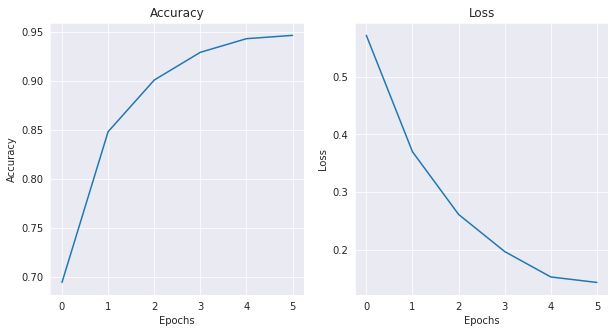

In [35]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(history.history["accuracy"])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

ax2.plot(history.history["loss"])
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
plt.show()

In [36]:
import numpy as np

data_test = pd.read_csv(r'/content/drive/My Drive/DM/data/processed_test.txt',sep = ',',
                         encoding = 'utf-8', header=None)

data_answer = pd.read_csv(r'/content/drive/My Drive/DM/data/answer.csv',sep = ',',
                         encoding = 'utf-8', header=None, index_col=0)

VOC_SIZE = 30000

print(data_test[2])
test = np.array(data_test[2],dtype = str)
onehot_repr = [one_hot(words, VOC_SIZE) for words in test]

SENT_LENGTH = 15
embedded_docs = pad_sequences(onehot_repr, padding="post", maxlen=SENT_LENGTH)
embedded_docs

pred = model.predict(embedded_docs)
data_answer = np.array(data_answer[1][1:],dtype=int)

0                                happen terribl car crash
1           heard earthquak differ citi stay safe everyon
2       forest fire spot pond gees flee across street ...
3                          apocalyps light spokan wildfir
4                      typhoon soudelor kill china taiwan
                              ...                        
3258        earthquak safeti los angel safeti fasten xrwn
3259    storm wors last hurrican cityand other hardest...
3260                            green line derail chicago
3261                  meg issu hazard weather outlook hwo
3262      cityofcalgari activ municip emerg plan yycstorm
Name: 2, Length: 3263, dtype: object


In [37]:
correct=0
sums=0
for i in range(len(pred)):
  if (pred[i] < 0.5):
    pred[i] = 0
  else:
    pred[i] = 1
  if (pred[i] == data_answer[i]):
    correct+=1
  sums+=1
    
print(correct/sums)

0.7106956788231689
